<a href="https://colab.research.google.com/github/hajihye123/MachineLearning_Lecture/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_3%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#제3장. 분류

In [1]:

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 3-1. MNIST

In [2]:
# 데이터 가져오기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) # 이미지 데이터(2차원 리스트를 1차원으로 변형함. 28*28=784)

X, y = mnist["data"], mnist["target"] # mnist는 딕셔너리 형태

In [3]:
# 범주형 데이터 -> 수치형 데이터

y = y.astype(np.uint8)

In [4]:
# 훈련/평가 데이터 나누기

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3-2. 이진 분류기

In [5]:
# 이진 클래스 만들기(5를 판별할 수 있도록)

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train[:5])
print(y_train_5[:5])

[5 0 4 1 9]
[ True False False False False]


In [6]:
# 이진 분류기 학습

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # 1000번의 학습
sgd_clf.fit(X_train, y_train_5) # fit(독립된 입력변수, 종속된 출력): 학습 데이터를 Classifier에 입력
sgd_clf.predict(X_train[:5])

array([ True, False, False, False, False])

In [7]:
# 교차 검증을 사용한 정확도 측정

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# cv값-> 분할 3번(아래 그림은 cv=5인 경우)
# 아래 array는 정확도를 나타냄

array([0.95035, 0.96035, 0.9604 ])

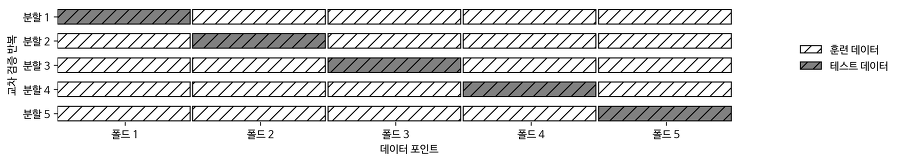

In [9]:
# 교차 검증을 사용한 정밀도/재현률 측정

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


from sklearn.metrics import precision_score, recall_score, f1_score
print("정밀도:", precision_score(y_train_5, y_train_pred))
print("재현률:", recall_score(y_train_5, y_train_pred))
print("F1    :", f1_score(y_train_5, y_train_pred)) # 정밀도와 재현률의 조화평균

정밀도: 0.8370879772350012
재현률: 0.6511713705958311
F1    : 0.7325171197343846


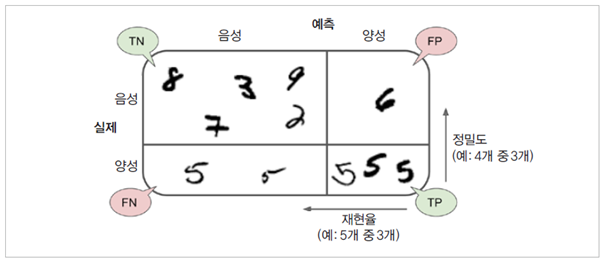

그림 저장: precision_recall_vs_threshold_plot


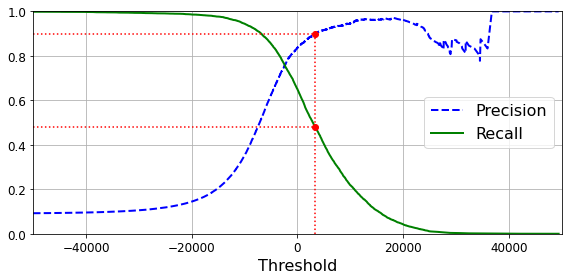

In [10]:
# 정밀도/재현률 트레이드오프

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()
# Precision: 정밀도
# Recall: 재현률
# Threshold > 0: Positive case / Threshold < 0: Negative case

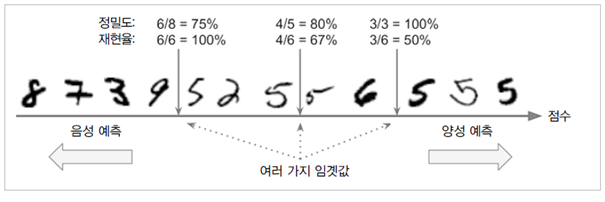

그림 저장: roc_curve_plot


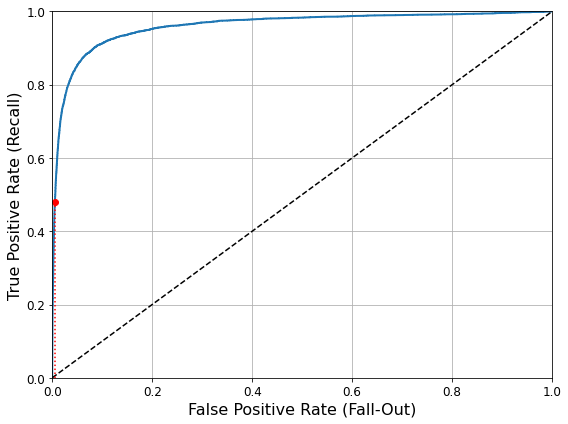

In [11]:
# ROC 곡선

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()
# TP: 재현률(실제 양성을 양성으로 판단)
# FP: 실제 음성을 양성으로 판단

그림 저장: roc_curve_comparison_plot


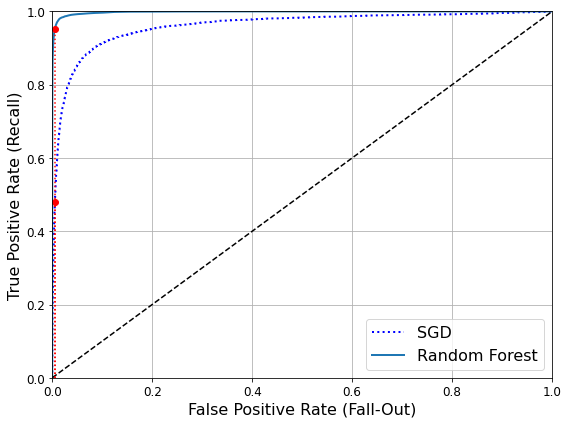

In [12]:
# ROC 곡선을 이용한 이진 분류기 성능 비교

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42) # 랜덤 포레스트 생성
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [13]:
# AUC를 이용한 이진 분류기 성능 비교

from sklearn.metrics import roc_auc_score

print("SGD:", roc_auc_score(y_train_5, y_scores)) # roc_auc_score(실제값, 예측값)
print("Random Forest:", roc_auc_score(y_train_5, y_scores_forest))

SGD: 0.9604938554008616
Random Forest: 0.9983436731328145


In [15]:
# Test data에 대한 성능 비교

y_pred_sgd = sgd_clf.predict(X_test)
print("[SGD]")
print("정밀도: ", precision_score(y_test_5, y_pred_sgd))
print("재현률: ", recall_score(y_test_5, y_pred_sgd))
print("F1: ", f1_score(y_test_5, y_pred_sgd))

forest_clf.fit(X_train, y_train_5)
y_pred_RF = forest_clf.predict(X_test)
print("[Random Forest]")
print("정밀도: ", precision_score(y_test_5, y_pred_RF))
print("재현률: ", recall_score(y_test_5, y_pred_RF))
print("F1: ", f1_score(y_test_5, y_pred_RF))

[SGD]
정밀도:  0.6618887015177066
재현률:  0.8800448430493274
F1:  0.75553416746872
[Random Forest]
정밀도:  0.993581514762516
재현률:  0.8677130044843049
F1:  0.926391382405745


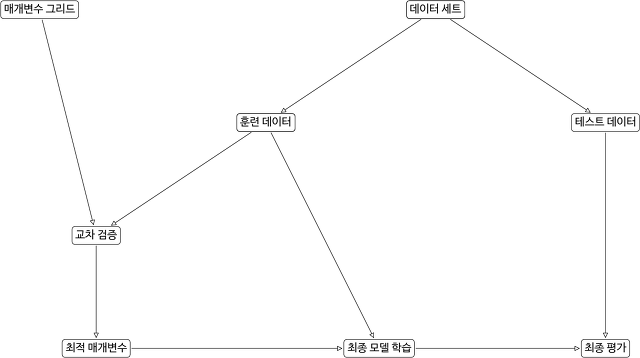

## 3-3. 다중 분류

In [17]:
# SVM을 이용한 다중 분류

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

print('실제값:', y_train[:5])
print('예측값:', svm_clf.predict(X_train[:5]))

실제값: [5 0 4 1 9]
예측값: [5 0 4 1 9]


In [18]:
# 10개의 이진 분류기를 이용한 다중 분류 결과

some_digit_scores = svm_clf.decision_function([X_train[0]])
print('OvR 점수:', some_digit_scores) # OvR 점수가 높으면 좋음
print('클래스:', svm_clf.classes_)
print('예측값:', svm_clf.classes_[np.argmax(some_digit_scores)])

OvR 점수: [[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]]
클래스: [0 1 2 3 4 5 6 7 8 9]
예측값: 5


In [20]:
# SGD 분류기를 이용한 다중분류

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
cv_score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
cv_score

KeyboardInterrupt: ignored

In [21]:
# 표준화를 이용한 성능 향상

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # 0~255를 0~1로 변환
cv_score = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
cv_score

array([0.8983, 0.891 , 0.9018])

In [ ]:
# 에러 분석

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

그림 저장: confusion_matrix_plot


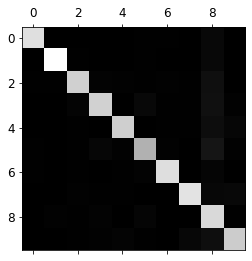

In [ ]:
# 오차 행렬을 이미지로 표현하기

plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

그림 저장: confusion_matrix_errors_plot


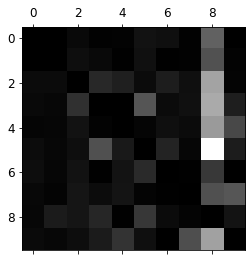

In [ ]:
# 오류를 이미지로 표현하기

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
display(row_sums)

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

그림 저장: error_analysis_digits_plot


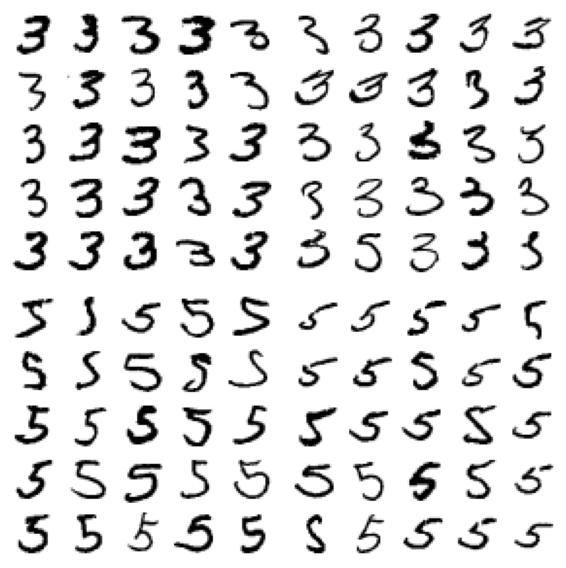

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

X_aa = X_train[(y_train == 3) & (y_train_pred == 3)]
X_ab = X_train[(y_train == 3) & (y_train_pred == 5)]
X_ba = X_train[(y_train == 5) & (y_train_pred == 3)]
X_bb = X_train[(y_train == 5) & (y_train_pred == 5)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### 참고1. 다중 레이블 분류

* 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 경우 학습
  * 예: 얼굴 인식 분류기
    * 한 사진에 여러 사람이 있다면, 인식된 사람마다 하나씩 꼬리표(tag)를 붙여야 함. 
    * 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정해봅시다. 
    * 분류기가 앨리스와 찰리가 있는 사진을 본다면 [1, 0, 1]을 출력해야 할 것입니다(즉, ‘앨리스 있음, 밥 없음, 찰리 있음’). 
    * 이처럼 여러 개의 이진 꼬리표를 출력하는 분류 시스템이 다중 레이블 분류 시스템.
  * 다중 레이블 분류기를 평가하는 방법은 다양함
    * 모든 레이블의 가중치가 같다고 가정: 각 레이블의 F1 점수를 구하고 평균 점수를 계산
    * 가중치: 레이블에 클래스의 지지도(즉, 타깃 레이블에 속한 샘플 수)를 가중치로 주기 



In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
display(y_train[:5])
display(y_multilabel[:5])

array([5, 0, 4, 1, 9], dtype=uint8)

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True]])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict(X_train[:1])

array([[False,  True]])

### 참고2. 다중 출력 분류

* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것, 즉, 값을 두 개 이상 가질 수 있음


In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


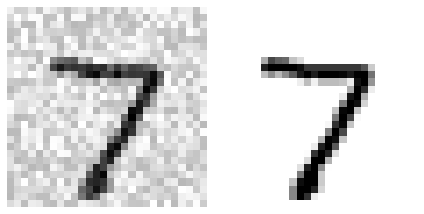

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

그림 저장: cleaned_digit_example_plot


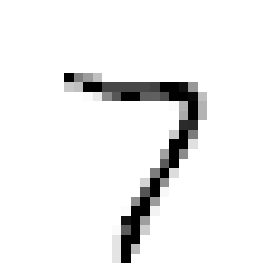

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

## 연습문제 - 타이타닉 데이터셋

* https://www.kaggle.com/c/titanic

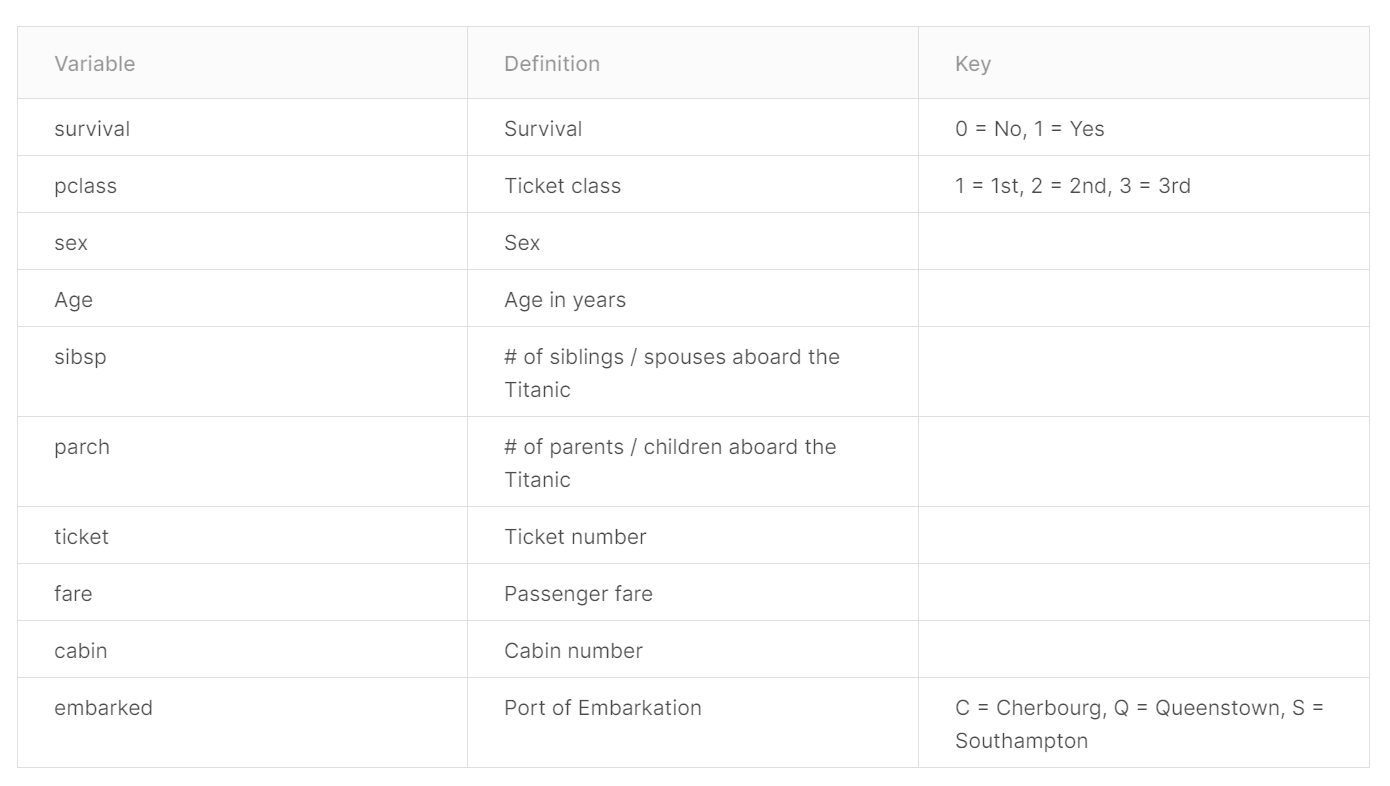

In [22]:
# 데이터 업로드

from google.colab import files

files.upload()
files.upload()

Saving test.csv to test.csv


Saving train.csv to train.csv


{'train.csv': b'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked\r\n1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S\r\n2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C\r\n3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S\r\n4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S\r\n5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S\r\n6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q\r\n7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S\r\n8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S\r\n9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S\r\n10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C\r\n11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S\r\n12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.55,C103,S\r\

In [23]:
import pandas as pd

train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [24]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* Survived: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* Pclass: 승객 등급. 1, 2, 3등석.
* Name, Sex, Age: 이름 그대로 의미입니다.
* SibSp: 함께 탑승한 형제, 배우자의 수.
* Parch: 함께 탑승한 자녀, 부모의 수.
* Ticket: 티켓 아이디
* Fare: 티켓 요금 (파운드)
* Cabin: 객실 번호
* Embarked: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

In [25]:
# info()로 훈련 데이터의 갯수, 자료형, 결측치 등 확인

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [37]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [38]:
train_data[['Age', 'Survived']].groupby('Age').mean()

,Survived
Age,
0.42,1.0
0.67,1.0
0.75,1.0
0.83,1.0
0.92,1.0
...,...
70.00,0.0
70.50,0.0
71.00,0.0


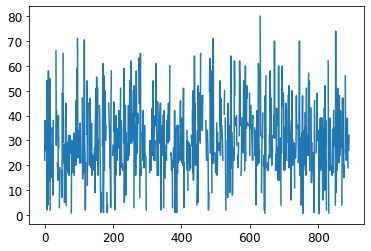

In [39]:
train_data['Age'].plot()

In [40]:
train_data[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [41]:
train_data[['Sex', 'Survived']].groupby('Sex', as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [42]:
pd.cut(train_data['Age'], 5)

0      (16.336, 32.252]
1      (32.252, 48.168]
2      (16.336, 32.252]
3      (32.252, 48.168]
4      (32.252, 48.168]
             ...       
886    (16.336, 32.252]
887    (16.336, 32.252]
888                 NaN
889    (16.336, 32.252]
890    (16.336, 32.252]
Name: Age, Length: 891, dtype: category
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] <
                                    (48.168, 64.084] < (64.084, 80.0]]

In [43]:
train_test_data = (train_data, test_data)

for dataset in train_test_data:
  dataset['AgeBin'] = pd.cut(dataset['Age'], 5)

In [44]:
train_data[['AgeBin', 'Survived']].groupby('AgeBin').mean()

,Survived
AgeBin,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.369942
"(32.252, 48.168]",0.404255
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [26]:
# describe()로 수치 데이터의 정보 확인

train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [45]:
corr_matrx = train_data.corr()
corr_matrx['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

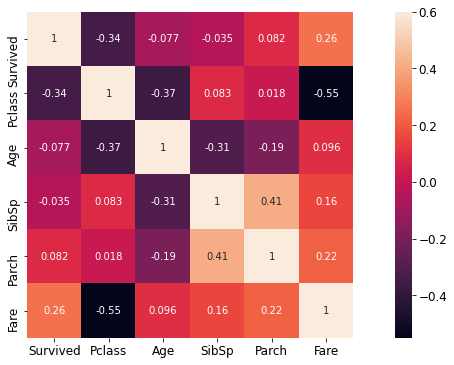

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.heatmap(train_data.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

In [27]:
# target data인 'Survived' 확인

train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [29]:
# 속성 선택을 위한 처리기

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
# 수치형 데이터 파이프라인

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [30]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [31]:
# 범주형 데이터의 결측치 처리기

# stackoverflow.com/questions/25239958 에서 착안했습니다
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [32]:
# 범주형 데이터 처리를 위한 파이프 라인 만들기

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [33]:
# 전체 파이프라인

from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
])

In [34]:
# 분류기 학습

X_train = full_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [47]:
y_train = train_data["Survived"]

In [48]:
# 평가 데이터에 대한 최종 결과 출력

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier()
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8070287141073658

In [49]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
forest_clf.predict(X_train)

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,